##### PyMC3 Examples

# GLM Model Selection


**A minimal reproducable example of Model Selection using DIC, WAIC and Bayes Factor.**

+ This example evaluates two different regression models and declares which has the better fit according to a Bayes Factor comparison.
+ The example is adapted specifically from Jake Vanderplas' [recent blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on model selection, for which he used an emcee sampler and numpy-based likelihood. The main purpose of this Notebook is to create a PyMC3-based version.
+ See also this question on [Cross Validated](http://stats.stackexchange.com/questions/161082/bayesian-model-selection-in-pymc3) 
+ The dataset is tiny and generated within this Notebook. It contains errors in the measured value (y) only.


**Note:**

+ Python 3.4 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.  
+ Finally, if runs become unstable or Theano throws weird errors, try clearing the cache `$> theano-cache clear` and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.4
      - ipython
      - ipython-notebook
      - ipython-qtconsole
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip

$> conda env create --file conda_env_pymc3_examples.yml

$> source activate pymc3_examples

$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```


+ [Setup](Setup)




# Setup

In [188]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_powell
from scipy import integrate
from scipy.stats import 

import pymc3 as pm
import theano as thno
import theano.tensor as T 

from IPython.html.widgets import interactive, fixed

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

## Local Functions

In [3]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    ''' 
    Create an example dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optional outliers from unknown sources

    Model form: y ~ a + bx + cx^2 + e
    
    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process' 
    generating thses values, rather than experimental measurement error. 
    Please don't use the returned `latent_error` values in inferential 
    models, it's there for interest only.
    '''
    
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
                
    ## create linear model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## create latent noise and marked outliers
    df['latent_error'] = rndst.normal(0,latent_sigma_y,n)
    df['outlier_error'] = rndst.normal(0,latent_sigma_y*10,n)
    df['outlier'] = rndst.binomial(1,p,n)
    
    ## add noise, with extreme noise for marked outliers
    df['y'] += (1-df['outlier']) * df['latent_error']
    df['y'] += df['outlier'] * df['outlier_error']
   
    ## round and return
    for col in ['y','latent_error','outlier_error','x']:
        df[col] = np.round(df[col],3)
       
    return df



def sketch_data(n=20, p=0, a=-30, b=5, c=0, latent_sigma_y=20):
    ''' Sketch the generated data '''
    
    df = generate_data(n, p, a, b, c, latent_sigma_y)
    ordr = 'linear' if c == 0 else 'quadratic'
    
    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              , ls='', elinewidth=0.7).add_legend()

    plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1
                        ,df['x'].max() + np.ptp(df['x'])*.1, 100)
    ploty = a + b*plotx + c*plotx**2

    _ = plt.plot(plotx, ploty, '--', alpha=0.8)
    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(ordr)
                       ,fontsize=16)
    

    
def plot_traces(traces, retain=1000):
    ''' 
    Convenience function for plotting traces with overlaid means and values
    '''
    
    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

        
    
def create_poly_modelspec(k=1):
    ''' Convenience function to create a polynomial modelspec string 
    '''
    return ('y ~ 1 + x ' + ' '.join(['+ np.power(x,{})'.format(j) 
                                     for j in range(2,k+1)])).strip()



def run_models(df, upper_order=5):
    ''' 
    Convenience fn to fit a range of models of increasing polynomial 
    complexity. Suggest limit to max order 5: calculation time is exponential.
    '''
    
    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.glm(fml, df, family=pm.glm.families.Normal())

            start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
            traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True) 
            
    return models, traces



def plot_posterior_cr(models=models_lin, traces=traces_lin, rawdata=dfs_lin,
                      datamodelnm='linear', modelnm='k1'):
    '''
    Convenience fn to plot posterior predictions with credible regions
    shown as filled areas.
    Choice of quartiles or mean & sd.
    '''
    
    ## Get traces and calc posterior prediction for npoints in x
    npoints = 100
    mdl = models[modelnm]
    trc = pm.trace_to_dataframe(traces[modelnm][-1000:])
    trc = trc[[str(v) for v in mdl.cont_vars[:-1]]]

    ordr = int(modelnm[-1:])
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
    X = x ** pwrs
    cr = np.dot(X,trc.T)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Greens')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
                        datamodelnm, modelnm), fontsize=16)
    plt.subplots_adjust(top=0.95)

    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(dfs_lin_xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
                   ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


# Create Data

## Interactively Draft Data

We'll generate a dummy dataset based on a specific distribution, so we can better evaluate the correctness of the automated model selection later.

Use the interactive plot below to get a feel for the possibilities of data we could generate.

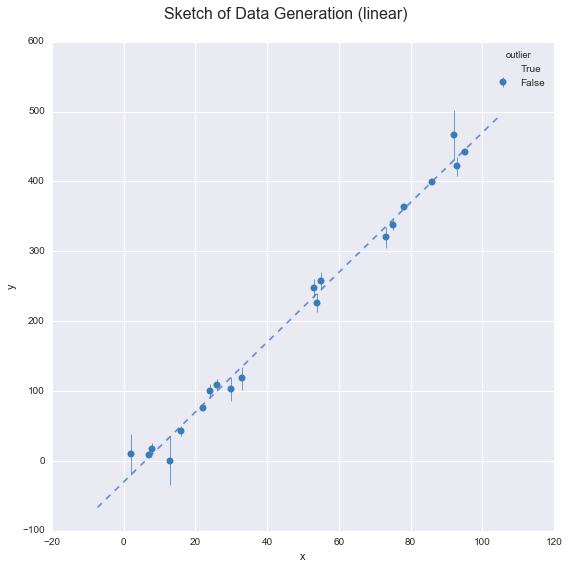

In [4]:
interactive(sketch_data, n=[5,50,5], p=[0,.5,.05], a=[-50,50], b=[-10,10], c=[-3,3]
            ,latent_sigma_y=[0,1000,50])

**Observe:**

+ I've shown the `latent_error` in errorbars, but this is for interest only, since this shows the _inherent noise_ in whatever 'physical process' we imagine created the data.
+ There is no _measurement error_.
+ Datapoints created as outliers are shown in **red**, again for interest only.

## Create Datasets for Modelling

We can use the above interactive plot to get a feel for the effect of the params. Now I'll create 2 fixed datasets to use for the remainder of the Notebook. 

1. For a start, I'll create a linear model with small noise. Keep it simple.
2. Secondly, a quadratic model with small noise

In [33]:
n = 12
df_lin = generate_data(n=n, p=0, a=-30, b=5, c=0, latent_sigma_y=40)
df_quad = generate_data(n=n, p=0, a=-200, b=2, c=3, latent_sigma_y=500)

##### Scatterplot

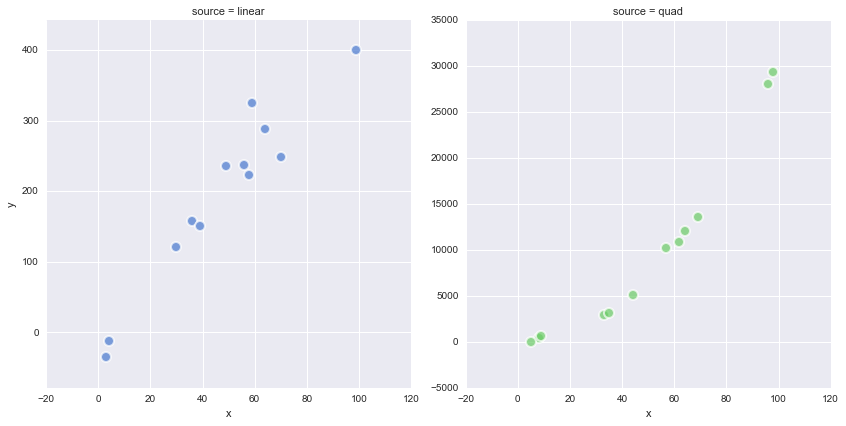

In [168]:
dfp = pd.concat((df_lin, df_quad), axis=0)
dfp['source'] = n * ['linear'] + n * ['quad']
g = sns.lmplot(x='x', y='y', col='source', hue='source', data=dfp, size=6
                ,fit_reg=False, sharey=False, legend=False
                ,scatter_kws={'alpha':0.7,'s':100,'lw':2,'edgecolor':'w'})

# tweak ylims for linear plot, seaborn sets a poor choice. bug?
_ = g.axes[0,0].set_ylim(df_lin['y'].min() - np.ptp(df_lin['y'])/10
                         , df_lin['y'].max() + np.ptp(df_lin['y'])/10)

### Standardize

In [35]:
dfs_lin = df_lin.copy()
dfs_lin['x'] = (df_lin['x'] - df_lin['x'].mean()) / df_lin['x'].std()

dfs_quad = df_quad.copy()
dfs_quad['x'] = (df_quad['x'] - df_quad['x'].mean()) / df_quad['x'].std()

##### Create ranges for later ylim xim

In [36]:
dfs_lin_xlims = (dfs_lin['x'].min() - np.ptp(dfs_lin['x'])/10
                 ,dfs_lin['x'].max() + np.ptp(dfs_lin['x'])/10)

dfs_lin_ylims = (dfs_lin['y'].min() - np.ptp(dfs_lin['y'])/10
                 ,dfs_lin['y'].max() + np.ptp(dfs_lin['y'])/10)

dfs_quad_ylims = (dfs_quad['y'].min() - np.ptp(dfs_quad['y'])/10
                 ,dfs_quad['y'].max() + np.ptp(dfs_quad['y'])/10)

---

# Create Simple OLS Model

This *linear model* is really simple and conventional:
$$y = a + bx + \epsilon$$



## Define model using ordinary pymc3 method

In [37]:
with pm.Model() as mdl_ols:
        
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)
 
    ## define Linear model
    yest = b0 + b1 * df_lin['x']

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv HalfT 1DoF)
    sigma_y = pm.HalfCauchy('sigma_y', beta=10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=df_lin['y'])

    ## sample using NUTS (starting from MAP found using powell)
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 71.361801
         Iterations: 8
         Function evaluations: 312
 [-----------------100%-----------------] 2000 of 2000 complete in 2.8 sec

##### View Traces after burn-in

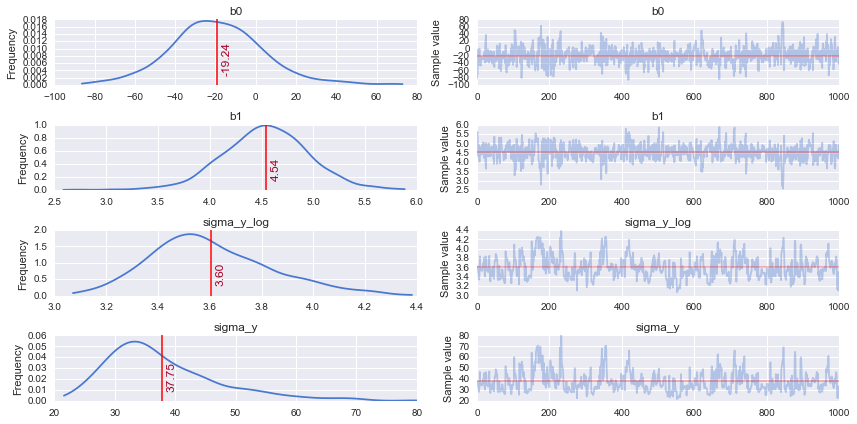

In [38]:
plot_traces(traces_ols, retain=1000)

**Observe:**

+ This simple OLS manages to make fairly good guesses - the data has been generated fairly simply after all - but it does appear to have been fooled by the inherent noise and outliers.


## Define model using pymc3 GLM method

PyMC3 has a quite recently developed method - `glm` - for defining models using a `patsy`-style formula syntax. This seems really useful, especially for defining simple regression models in fewer lines of code. 

I couldn't find a direct comparison in the the examples, so before I launch into using `glm` for the rest of the Notebook, here's the same OLS model as above, defined using `glm`.

In [39]:
with pm.Model() as mdl_ols_glm:

    # setup model with Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df_lin, family=pm.glm.families.Normal())
    
    ## sample using NUTS (starting from MAP found using powell)
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)
    traces_ols_glm = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 89.753579
         Iterations: 8
         Function evaluations: 313
 [-----------------100%-----------------] 2000 of 2000 complete in 4.1 sec

##### View Traces after burn-in

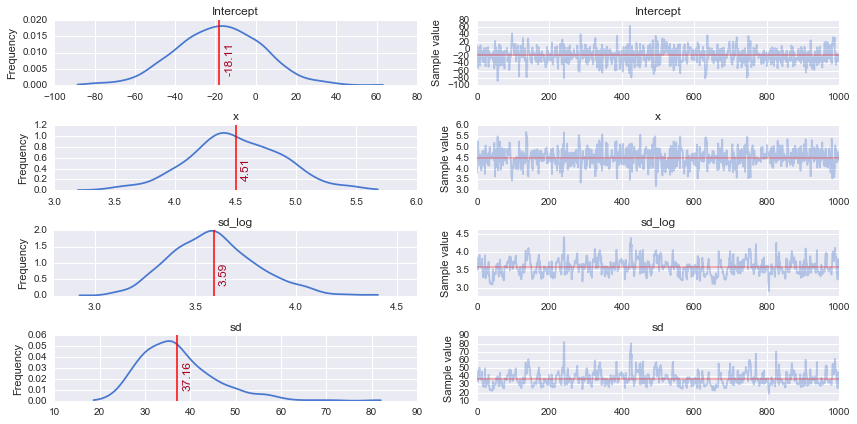

In [40]:
plot_traces(traces_ols_glm, retain=1000)

**Observe:**

+ The output parameters are of course named differently to my custom naming before. Now we have:

    `b0 == Intercept`  
    `b1 == x`  
    `sigma_y_log == sd_log`  
    `sigma_y == sd`  
    
    
+ However, naming aside, this `glm`-defined model appears to behave in a very similar way, and finds the same parameter values as the conventionally-defined model - any differences are due to the random nature of the sampling.
+ I'll quite happily use the `glm` syntax for further models below, since it allows a model factory approach.

---

# Compare Higher-Order OLS Models

Back to the real purpose of this Notebook: demonstrate model selection

## Create and run polynomial models

In [43]:
models_lin, traces_lin = run_models(dfs_lin)


Running: k1
 [-----------------100%-----------------] 2000 of 2000 complete in 2.5 sec
Running: k2
 [-----------------100%-----------------] 2000 of 2000 complete in 3.4 sec
Running: k3
 [-----------------100%-----------------] 2000 of 2000 complete in 7.1 sec
Running: k4
 [-----------------100%-----------------] 2000 of 2000 complete in 11.6 sec
Running: k5
 [-----------------100%-----------------] 2000 of 2000 complete in 28.4 sec

In [44]:
models_quad, traces_quad = run_models(dfs_quad)


Running: k1
 [-----------------100%-----------------] 2000 of 2000 complete in 31.4 sec
Running: k2
 [-----------------100%-----------------] 2000 of 2000 complete in 16.4 sec
Running: k3
 [-----------------100%-----------------] 2000 of 2000 complete in 14.6 sec
Running: k4
 [-----------------100%-----------------] 2000 of 2000 complete in 53.3 sec
Running: k5
 [-----------------100%-----------------] 2000 of 2000 complete in 47.3 sec

## Really naive model selection: compare likelihoods

##### get negative log likelihoods straight from model.logp

In [335]:
dfll = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfll.index.name = 'model'

for nm in dfll.index:
    dfll.loc[nm,'lin'] =-models_lin[nm].logp(pm.df_summary(traces_lin[nm])['mean'].to_dict())
    dfll.loc[nm,'quad'] =-models_quad[nm].logp(pm.df_summary(traces_quad[nm])['mean'].to_dict())

dfll = pd.melt(dfll.reset_index(), id_vars=['model'], var_name='poly'
               ,value_name='log_likelihood')

##### Plot log-likelihoods

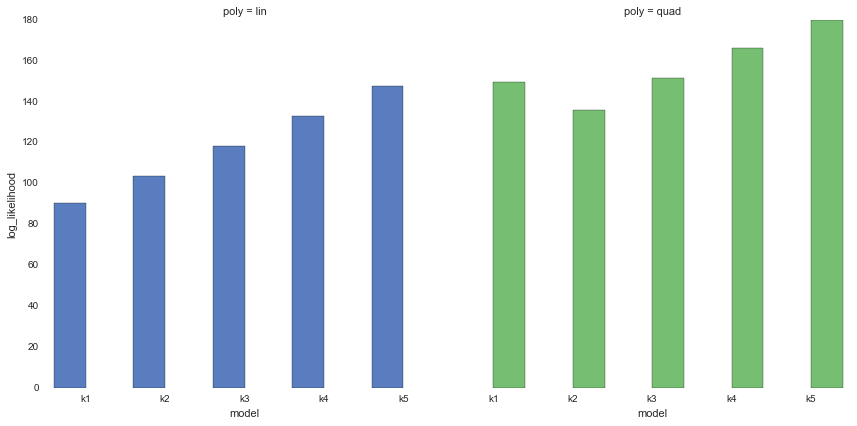

In [336]:
g = sns.factorplot(x='model', y='log_likelihood', col='poly', hue='poly'
                   ,data=dfll, kind='bar', size=6)

## View posterior predictive fit

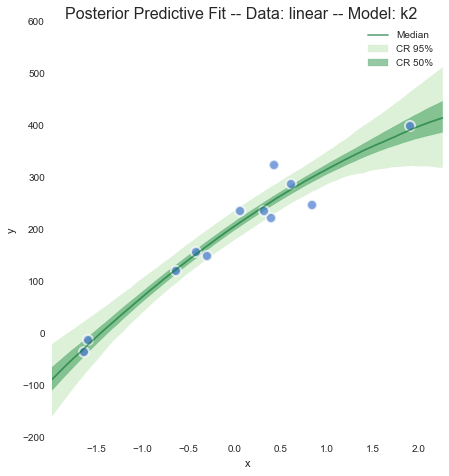

In [321]:
interactive(plot_posterior_cr, models=fixed(models_lin), traces=fixed(traces_lin)
            ,rawdata=fixed(dfs_lin), datamodelnm=fixed('linear')
            ,modelnm = ['k1','k2','k3','k4','k5'])

---

# Deviance Information Criterion (DIC)

##### Manual way, probably error-prone

In [48]:
dftrc_lin = pm.trace_to_dataframe(traces_lin['k1'])
trc_lin_logp = dftrc_lin.apply(lambda x: models_lin['k1'].logp(x.to_dict()), axis=1)
mean_deviance = -2 * trc_lin_logp.mean(0)
mean_deviance

183.40070708736644

In [49]:
deviance_at_mean = -2 * models_lin['k1'].logp(dftrc_lin.mean(0).to_dict())
deviance_at_mean

180.32065188088569

In [50]:
dic_k1 = 2 * mean_deviance - deviance_at_mean
dic_k1

186.48076229384719

##### Or we could use the newly created function in `stats.py`, much better!

In [51]:
pm.stats.dic(model=models_lin['k1'], trace=traces_lin['k1'])

186.48076229384691

##### Lets loop through all the models and calculate the DIC

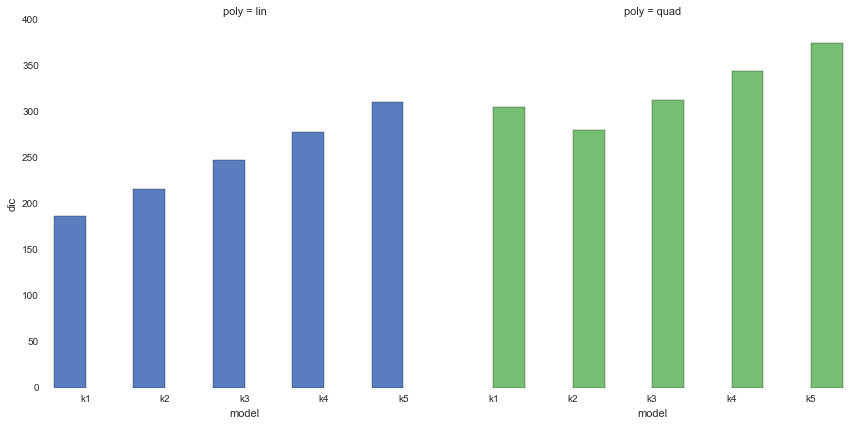

In [337]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.dic(traces_lin[nm],models_lin[nm])
    dfdic.loc[nm, 'quad'] = pm.stats.dic(traces_quad[nm],models_quad[nm])

dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='dic')

g = sns.factorplot(x='model', y='dic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)

**Observe**

+ The DIC increases monotonically with model complexity, this is great too see!
+ The more complicated the model, the more it would appear we are overfitting.
+ We should prefer the model(s) with lower DIC, which (happily) directly opposes the increasing likelihood we saw earlier. 

---

---

# Watanabe - Akaike Information Criterion (WAIC)

aka Widely Applicable Information Criterion

##### This time go straight for the implementation in pymc3

In [322]:
pm.stats.waic(model=models_lin['k1'], trace=traces_lin['k1'])

124.26568402263482

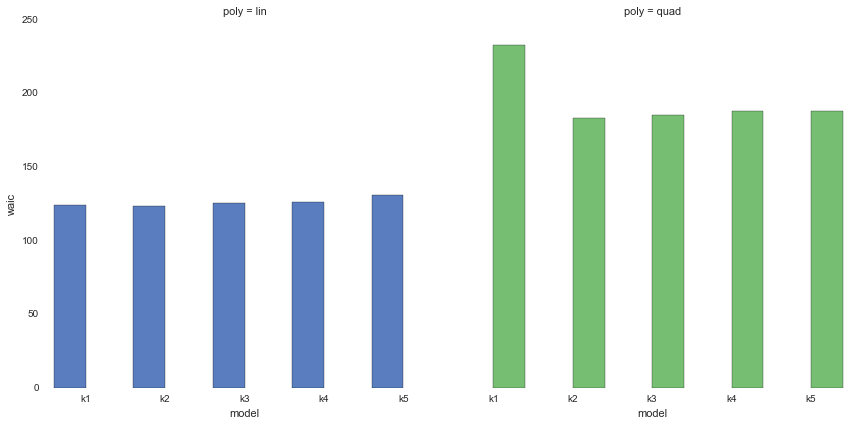

In [338]:
dfwaic = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfwaic.index.name = 'model'

for nm in dfwaic.index:
    dfwaic.loc[nm, 'lin'] = pm.stats.waic(traces_lin[nm],models_lin[nm])
    dfwaic.loc[nm, 'quad'] = pm.stats.waic(traces_quad[nm],models_quad[nm])

dfwaic = pd.melt(dfwaic.reset_index(), id_vars=['model'], var_name='poly', value_name='waic')

g = sns.factorplot(x='model', y='waic', col='poly', hue='poly', data=dfwaic, kind='bar', size=6)

---

---

# Bayes Factor

##### Will be left for future development

Following text lifted directly from [JakeVDP blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/)

The Bayesian approach proceeds very differently. Recall that the Bayesian model involves computing the odds ratio between two models:

$$O_{21}=\frac{P(M_{2} \;|\; D)}{P(M_{1} \;|\; D)}=\frac{P(D \;|\; M_{2})}{P(D \;|\; M_{1})}\frac{P(M_{2})}{P(M_{1})}$$

Here the ratio $\frac{P(M2)}{P(M1)}$ is the prior odds ratio, and is often assumed to be equal to 1 if no compelling prior evidence favors one model over another. The ratio $\frac{P(D \;|\; M2)}{P(D \;|\; M1)}$ is the **Bayes factor**, and is the key to Bayesian model selection.


The Bayes factor can be computed by evaluating the integral over the parameter likelihood:

$$P(D \;|\; M)=\int_{\Omega}P(D \;|\; \theta,M) \; P(\theta \;|\; M) \;d\theta$$

This integral is over the entire parameter space of the model, and thus can be extremely computationally intensive, especially as the dimension of the model grows beyond a few. 

---

Example originally contributed by Jonathan Sedar 2015-12-30 [github.com/jonsedar](https://github.com/jonsedar)